In [1]:
%%capture

from lmi import lmi
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import time
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
pxf = pd.read_csv('../data/ProtT5_embeddings/OP_kinases.csv', index_col=0)
kinases = [x for x in pxf.keys() if x[:7] == 'Kinase_']
targets = [x for x in pxf.keys() if x[:7] == 'Target_']

In [3]:
def batch_ksg(X, Y, batch_size=10**3):
    """
    since this dataset is so big, here we implement a batched KSG.
    we make batches of 5000 points, estimate MI on each, then take the average pSIMI.
    approach used in https://doi.org/10.1103/PhysRevE.100.022404
    """
    psimis = []
    inds = np.arange(len(X))
    np.random.shuffle(inds)
    Xs = X.iloc[inds]
    Ys = Y.iloc[inds]
    for i in tqdm(range(len(Xs)//batch_size)):
        b_psimis = lmi.ksg.mi(Xs[batch_size*i:batch_size*(i+1)],
                              Ys[batch_size*i:batch_size*(i+1)])
        psimis += list(b_psimis)
    return np.mean(psimis)

In [4]:
d = {
    "Estimator" : [],
    "Shuffled" : [],
    "Estimate" : []
}

N_shuffles = 10

for _ in tqdm(range(N_shuffles)):
    
    Xs, Ys = pxf[kinases].sample(frac=1), pxf[targets]
    
    infonce = InfoNCE(verbose=False)
    infonce_mi = infonce.estimate(Xs, Ys)
    
    mine = MINE(verbose=False)
    mine_mi = mine.estimate(Xs, Ys)
    
    psimis, emb, model = lmi.lmi(Xs, Ys)
    
    d['Estimator'].append('InfoNCE')
    d['Shuffled'].append(True)
    d['Estimate'].append(infonce_mi)
    
    d['Estimator'].append('MINE')
    d['Shuffled'].append(True)
    d['Estimate'].append(mine_mi)
    
    d['Estimator'].append('LMI')
    d['Shuffled'].append(True)
    d['Estimate'].append(np.nanmean(psimis))
    
    d['Estimator'].append('KSG')
    d['Shuffled'].append(True)
    d['Estimate'].append(batch_ksg(Xs, Ys))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
Xs, Ys = pxf[kinases], pxf[targets]

infonce = InfoNCE(verbose=False)
infonce_mi = infonce.estimate(Xs, Ys)
print(infonce_mi)
mine = MINE(verbose=False)
mine_mi = mine.estimate(Xs, Ys)

psimis, emb, model = lmi.lmi(Xs, Ys, N_dims=8, quiet=False)
print(np.nanmean(psimis))

d['Estimator'].append('InfoNCE')
d['Shuffled'].append(False)
d['Estimate'].append(infonce_mi)

d['Estimator'].append('MINE')
d['Shuffled'].append(False)
d['Estimate'].append(mine_mi)

d['Estimator'].append('LMI')
d['Shuffled'].append(False)
d['Estimate'].append(np.nanmean(psimis))

d['Estimator'].append('KSG')
d['Shuffled'].append(False)
d['Estimate'].append(batch_ksg(Xs, Ys))

df = pd.DataFrame(d)
df

9.5367431640625e-07


  0%|          | 0/300 [00:00<?, ?Epoch/s]

0.8186234720810627


  0%|          | 0/22 [00:00<?, ?it/s]

,Estimator,Shuffled,Estimate
0,InfoNCE,True,-1.964569e-04
1,MINE,True,0.000000e+00
2,LMI,True,-3.344048e-03
3,KSG,True,4.545769e-03
4,InfoNCE,True,9.536743e-06
5,MINE,True,7.152557e-07
6,LMI,True,-1.811156e-02
7,KSG,True,-4.374657e-03
8,InfoNCE,True,1.525879e-05
9,MINE,True,-1.705170e-03


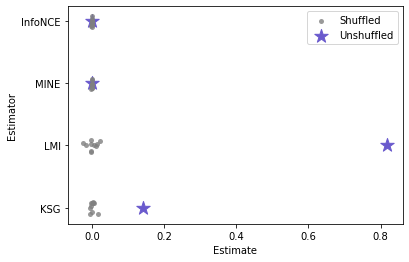

In [6]:
ax = sns.stripplot(df[df['Shuffled']], x='Estimate', y='Estimator',
             alpha=0.8, color='grey', label='Shuffled')

ax.scatter(df['Estimate'].iloc[-4], 0, s=200, marker='*', color='slateblue', label='Unshuffled')
ax.scatter(df['Estimate'].iloc[-3], 1, s=200, marker='*', color='slateblue')
ax.scatter(df['Estimate'].iloc[-2], 2, s=200, marker='*', color='slateblue')
ax.scatter(df['Estimate'].iloc[-1], 3, s=200, marker='*', color='slateblue')
ax.legend()

handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())

plt.show()

In [7]:
df.to_csv('../results/OP_kinase_shuffle.csv')

In [9]:
df[df['Shuffled']==True].groupby('Estimator').std()

,Shuffled,Estimate
Estimator,,
InfoNCE,0.0,0.000697
KSG,0.0,0.006307
LMI,0.0,0.014504
MINE,0.0,0.000815


In [10]:
df[df['Shuffled']==True].groupby('Estimator').mean()

,Shuffled,Estimate
Estimator,,
InfoNCE,1.0,-0.000274
KSG,1.0,0.000388
LMI,1.0,-0.000226
MINE,1.0,-0.000407
